In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_columns',105)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings 
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
locals = False

if locals:
    PATH = 'D:\\ML_Notes\\Kaggle\\house_price\\'
    
else:
    PATH = '../input/'

In [3]:
train = pd.read_csv(PATH + 'train.csv')
test = pd.read_csv(PATH + 'test.csv')

In [4]:
train.shape, test.shape

((15035, 21), (6468, 20))

In [5]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [6]:
train_id = train.id
test_id = test.id

# reference code for dropping outliers<br>
# https://www.kaggle.com/chocozzz/house-price-prediction-eda-updated-2019-03-12

train = train.loc[train['id']!=8990]    # sqft_living15의 outlier
train = train.loc[train['id']!=2302]    # grade 대비 price가 너무 높은 아이 

for df in [train, test]:     # month는 영향력 낮은 가운데서도 정말 영향력 없음.. 
    df['year_date'] = pd.to_numeric(df.date.str.slice(0, 4))
    df['yrmon_date'] = pd.to_numeric(df.date.str.slice(4, 8))
    df.drop(['id','date'], axis=1, inplace=True)
    
### 2015년의 feature들이 영향을 많이 끼침. 얘네들을 특별히 좀.. 어케-_- 할 수 없나? 
### 2015년 값들에 가중치를 더 준다던지 하는식으로.. -> prediction result가 이상해지지 않을까?
print(len(train.loc[train['year_date']==2015])/train.shape[0])    
print(len(test.loc[test['year_date']==2015])/test.shape[0])

0.31963014700991155
0.32266542980828694


#### step.1. CLEAN THE DATA - check the null values & duplicates in the data

In [7]:
# train.isnull().sum()

In [8]:
# test.isnull().sum()

In [9]:
print('former:', train.shape, test.shape)
train.drop_duplicates()
test.drop_duplicates()
print('latter:', train.shape, test.shape)

former: (15033, 21) (6468, 20)
latter: (15033, 21) (6468, 20)


Alright, we have no null valus and no duplicates rows.

#### step.2. CLEAN THE DATA - Let's explore the data more specifically<br>
아래 셀 코드 출처 <br>
https://www.kaggle.com/yeonmin/default-eda-stacking-introduction

In [10]:
default_check = pd.concat([train.isnull().sum(), train.dtypes, 
                            train.nunique(),train.describe().T], axis=1)
default_check.rename(columns={0:'NULL', 1:'TYPE', 2:'UNIQUE'}, inplace=True)
default_check

,NULL,TYPE,UNIQUE,count,mean,std,min,25%,50%,75%,max
price,0,float64,3263,15033.0,540721.525311,371534.054816,78000.0000,322000.0000,450000.0000,645000.0000,7.700000e+06
bedrooms,0,int64,11,15033.0,3.369321,0.902569,0.0000,3.0000,3.0000,4.0000,1.000000e+01
bathrooms,0,float64,29,15033.0,2.115230,0.767436,0.0000,1.7500,2.2500,2.5000,8.000000e+00
sqft_living,0,int64,863,15033.0,2083.965010,922.066383,290.0000,1430.0000,1914.0000,2560.0000,1.354000e+04
sqft_lot,0,int64,7676,15033.0,15297.726801,42615.586918,520.0000,5027.0000,7620.0000,10695.0000,1.651359e+06
floors,0,float64,6,15033.0,1.498137,0.538527,1.0000,1.0000,1.5000,2.0000,3.500000e+00
waterfront,0,int64,2,15033.0,0.007118,0.084068,0.0000,0.0000,0.0000,0.0000,1.000000e+00
view,0,int64,5,15033.0,0.234285,0.763422,0.0000,0.0000,0.0000,0.0000,4.000000e+00
condition,0,int64,5,15033.0,3.406572,0.646409,1.0000,3.0000,3.0000,4.0000,5.000000e+00
grade,0,int64,12,15033.0,7.661145,1.179191,1.0000,7.0000,7.0000,8.0000,1.300000e+01


### step.2. check the distribution difference between train and test data  

Test data와 train data간의 distribution이 얼마나 다른지 체크<br>
코드 출처 : https://www.kaggle.com/yeonmin/default-eda-stacking-introduction

In [11]:
# train.columns, test.columns

================================== BATHROOM ===================================<br>
the unique values of train data is more larger than the test's. So just let them go.<br>

Float values in bathrooms column means<br>
https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr/discussion/83533 <br>
1 : (full bath) containing four plumbing fixtures; a toilet and sink, bathtub and shower<br>
0.75 : (3/4 bath) toilet, sink and shower<br>
0.5 : (half bath) bathtub, sink and shower<br>

bathrooms 애들을 categorize해서, 새로운 feature로 하나 넣어주자 -> 어차피 gbm 안에서 categorize되므로 필요없음 (공연히 preprocessing 시간만 잡아먹는거 같아서 안 함)
* <br><br> # 혹시 성능 좋아질지도 모르니 한 번 해보자 -> 칼럼이 따로 만들어져서, train/test 칼럼간 불균형이 발생했는데 해결할 방법을 몰라서 폐기..

In [12]:
#### 얘네 두 개가 train set에 bedrooms 개수가 없는 애들
# test.loc[test.bedrooms==11]
# test.loc[test.bedrooms==33]

#### ADD FEATURES - yr_renovated<br>
https://www.kaggle.com/chocozzz/house-price-prediction-eda-updated-2019-03-12 레퍼런스해서 수정하고 추가한 코드들<br>
2015년 이후 renovated된 건물은 없음. 2014년도가 최대임. 고로 이 데이터에서는 2015년 기준 값들이 가장 최신임<br>
renovate는 다 쓰러져가는 상태의 (비교적 큰) 건물을 좋은 상태로 복구하는 것-이라고 한다. (출처 : https://m.blog.naver.com/christinehlee/220855094350)<br>

In [13]:
### Fill np.nan if there is 0 in 'yr_renovated', otherwise fill with 'yr_renovated' value
    
train['building_age'] = train.yr_built
test['building_age'] = test.yr_built
    
# renovated된 것 뒤에 기존 building age를 작게 scaling해서 넣어줬는데.. 사실상 값 차이가 없음. 걍 뺌
# 2019년에서 빼면 파는 시기와는 아예 상관이 없자너... 수정해줌
for idx, value in enumerate(train.yr_renovated):
    if value > 0.0:
        train['building_age'].iloc[idx] = train['year_date'].iloc[idx] - value   
    else:
        train['building_age'].iloc[idx] = train['year_date'].iloc[idx] - train['yr_built'].iloc[idx] 

        
for idx, value in enumerate(test.yr_renovated):
    if value > 0.0:
        test['building_age'].iloc[idx] = train['year_date'].iloc[idx] - value       
    else:
        test['building_age'].iloc[idx] = train['year_date'].iloc[idx] - test['yr_built'].iloc[idx]     


# print(train['building_age'].isnull().sum() , test['building_age'].isnull().sum())
# print(train.building_age.mean())

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [14]:
from sklearn.decomposition import PCA

coord = train[['lat','long']]
pca = PCA(n_components=2)
pca.fit(coord)
coord_pca = pca.transform(coord)

train['coord_pca1'] = coord_pca[:, 0]
train['coord_pca2'] = coord_pca[:, 1]

coord = test[['lat','long']]
pca = PCA(n_components=2)
pca.fit(coord)
coord_pca = pca.transform(coord)

test['coord_pca1'] = coord_pca[:, 0]
test['coord_pca2'] = coord_pca[:, 1]

print(train['coord_pca1'])
print('')
print(test['coord_pca2'])

0       -0.001100
1       -0.129104
2        0.092653
3        0.075504
4        0.020248
5        0.026669
6       -0.143247
7       -0.137604
8        0.095299
9       -0.208241
10      -0.130083
11       0.084459
12      -0.165932
13       0.165381
14       0.075664
15      -0.188740
16       0.004062
17       0.170326
18       0.152446
19       0.161917
20      -0.162004
21      -0.116221
22       0.123714
23      -0.196323
24      -0.205929
25       0.129239
26      -0.152283
27      -0.183930
28       0.094123
29       0.045509
           ...   
15005   -0.098326
15006    0.039507
15007    0.123973
15008   -0.163318
15009    0.066641
15010   -0.091208
15011   -0.082602
15012   -0.168104
15013    0.277608
15014   -0.199216
15015   -0.140070
15016    0.267626
15017   -0.198764
15018   -0.184439
15019   -0.197344
15020    0.285536
15021    0.055054
15022    0.041325
15023    0.201445
15024    0.113853
15025   -0.010054
15026    0.047414
15027   -0.035607
15028   -0.167171
15029    0

In [15]:
for df in [train, test]:
    df['view'] = np.log1p(df['view'])
    df['yr_built'] = df['yr_built'] - 1900
    df['sqft_lot15'] = np.log1p(df['sqft_lot15'])
    df['waterfront'] = np.log1p(df['waterfront'])
    df['yr_renovated'] = np.log1p(df['yr_renovated'])
    df['sqft_living'] = np.log1p(df['sqft_living'])
    df['sqft_living15'] = np.log1p(df['sqft_living15'])
    df['sqft_above'] = np.log1p(df['sqft_above'])
    df['condition'] = np.log1p(df['condition'])

    df['total_rooms'] = df['bedrooms'] + df['bathrooms'] + 2          # +2를 해주는 이유는 total_rooms가 0인 애들이 있어서.. 2인 이유는 divide 해줬을 때 좀 effect가 있어야 하니까.
    df['sqft_all'] = np.log1p(df['sqft_living'] + df['sqft_lot'] + df['sqft_above'] + df['sqft_basement'])
    df['sqft_all15'] = np.log1p(df['sqft_living15'] + df['sqft_lot15'] + df['sqft_above'] + df['sqft_basement'])
    df['sqft_total_size'] = np.log1p(df['sqft_living'] + df['sqft_lot'])
    df['sqft_total_size15'] = np.log1p(df['sqft_living15'] + df['sqft_lot15'])
    df['sqft_ratio15'] = np.round(df['sqft_living15'] / df['sqft_lot15'], decimals=3)
    df['sqft_ratio'] = df['sqft_living'] / df['sqft_lot']
    print('first feature process is done')
    
    df['garden_area15'] = np.abs(df['sqft_above'] - df['sqft_living15'])
    df['space_for_rooms'] = df['sqft_living'] / (df['bedrooms'] + 2)  # bedroom 0인 애들이 있음. 2는 너무 값이 크게나와서 좀 줄여줄려공
    df['space_per_floor'] = df['sqft_living'] / df['floors']        # space per floor
    print('second feature process is done')
    
    ### optional features  # brute force...
    df['grade_square'] = df['grade'] ** 2
    df['bathrooms_square'] = df['bathrooms'] ** 2
    
#     df['sqft_living15_square'] = np.round(np.log1p(df['sqft_living15'] ** 2), decimals=3)
    df['sqft_lot15_square'] = np.round(np.log1p(df['sqft_lot15'] ** 2), decimals=3)
    df['sqft_living_square'] = np.round(np.log1p(df['sqft_living'] ** 2), decimals=3)
    df['sqft_lot_square'] = np.round(np.log1p(df['sqft_lot'] ** 2), decimals=3)
    
    # https://www.kaggle.com/jsdae1/house-price-prediction-challenge
#     df['sqft_lot_gap'] = df['sqft_lot15'] - df['sqft_lot']
    df['sqft_living_gap'] = df['sqft_living15'] - df['sqft_living']
    
    ### garret 부분 reference code : https://www.kaggle.com/marchen911/xgboost-lightgbm-catboost
    df['garret'] = (df.floors%1 == 0.5).astype(int)
    
    print("all thing's done")

first feature process is done
second feature process is done
all thing's done
first feature process is done
second feature process is done
all thing's done


In [16]:
train['per_price'] = train['price']/train['sqft_total_size']

zipcode_price = train.groupby(['zipcode'])['per_price'].agg({'mean','var'}).reset_index()

train = pd.merge(train,zipcode_price,how='left',on='zipcode')
test = pd.merge(test,zipcode_price,how='left',on='zipcode')

for df in [train, test]:
    df['zip_price_mean'] = df['mean'] * df['sqft_total_size']
    df['zip_price_var'] = df['var'] * df['sqft_total_size']
    
train.drop(columns=['sqft_lot','sqft_basement','per_price','mean','var'], axis=1, inplace=True)   # sqft_lot affects nothing..
test.drop(columns=['sqft_lot','sqft_basement','mean','var'], axis=1, inplace=True)            


# 아래 항목의 reference code : https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
skewed_columns = ['sqft_living','sqft_above','sqft_living15','sqft_lot15']

for i in skewed_columns:                           # log 해준 feature가 있냐 없냐는 결과에 영향이 없음 
    train[i] = np.log1p(train[i])
    test[i] = np.log1p(test[i])

print('done')

done


하단 코드의 레퍼런스 <br>
https://www.kaggle.com/junoindatascience/let-s-model-it

In [17]:
max_idx = train[train['price'] == train['price'].max()].index[0]
max_loc = np.array(train[['lat','long']].loc[max_idx, :])    # the location of the maximum price house
train_loc = np.array(train[['lat','long']])
test_loc = np.array(test[['lat','long']])

import scipy

train['max_distance'] = scipy.linalg.norm(max_loc - train_loc, axis=1)
test['max_distance'] = scipy.linalg.norm(max_loc - test_loc, axis=1)

zipcode features<br>
https://www.kaggle.com/tmheo74/geo-data-eda-and-feature-engineering<br>
zipcode의 세 자리 숫자를 쪼갬

In [18]:
train['zipcode-3'] = 'z_' + train['zipcode'].astype(str).str[2:3]
train['zipcode-4'] = 'z_' + train['zipcode'].astype(str).str[3:4]
train['zipcode-5'] = 'z_' + train['zipcode'].astype(str).str[4:5]
train['zipcode-34'] = 'z_' + train['zipcode'].astype(str).str[2:4]
train['zipcode-45'] = 'z_' + train['zipcode'].astype(str).str[3:5]
train['zipcode-35'] = 'z_' + train['zipcode'].astype(str).str[2:3] + train['zipcode'].astype(str).str[4:5]

test['zipcode-3'] = 'z_' + test['zipcode'].astype(str).str[2:3]
test['zipcode-4'] = 'z_' + test['zipcode'].astype(str).str[3:4]
test['zipcode-5'] = 'z_' + test['zipcode'].astype(str).str[4:5]
test['zipcode-34'] = 'z_' + test['zipcode'].astype(str).str[2:4]
test['zipcode-45'] = 'z_' + test['zipcode'].astype(str).str[3:5]
test['zipcode-35'] = 'z_' + test['zipcode'].astype(str).str[2:3] + test['zipcode'].astype(str).str[4:5]

print(train['zipcode-3'])
print('')
print(test['zipcode-35'].isnull().sum())

# zip_list = ['zipcode-3','zipcode-4','zipcode-5','zipcode-34','zipcode-45','zipcode-35']

for df in [train, test]:
    df['zipcode-3'] = df['zipcode-3'].loc[df['zipcode-3']  != 'z_']
    df['zipcode-4'] = df['zipcode-4'].loc[df['zipcode-4'] != 'z_']
    df['zipcode-5'] = df['zipcode-5'].loc[df['zipcode-5'] != 'z_']
    df['zipcode-34'] = df['zipcode-34'].loc[df['zipcode-34'] != 'z_']
    df['zipcode-45'] = df['zipcode-45'].loc[df['zipcode-45'] != 'z_']
    df['zipcode-35'] = df['zipcode-35'].loc[df['zipcode-35'] != 'z_']
       
print(train['zipcode-45'])


from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train['zipcode-3'] = le.fit_transform(train['zipcode-3'])
test['zipcode-3'] = le.fit_transform(test['zipcode-3'])

train['zipcode-4'] = le.fit_transform(train['zipcode-4'])
test['zipcode-4'] = le.fit_transform(test['zipcode-4'])

train['zipcode-5'] = le.fit_transform(train['zipcode-5'])
test['zipcode-5'] = le.fit_transform(test['zipcode-5'])

train['zipcode-34'] = le.fit_transform(train['zipcode-34'])
test['zipcode-34'] = le.fit_transform(test['zipcode-34'])

train['zipcode-45'] = le.fit_transform(train['zipcode-45'])
test['zipcode-45'] = le.fit_transform(test['zipcode-45'])

train['zipcode-35'] = le.fit_transform(train['zipcode-35'])
test['zipcode-35'] = le.fit_transform(test['zipcode-35'])


print(train['zipcode-3'])
print('*'*100)
print(test['zipcode-35'])

0        z_1
1        z_0
2        z_0
3        z_0
4        z_1
5        z_0
6        z_1
7        z_0
8        z_0
9        z_1
10       z_1
11       z_0
12       z_1
13       z_0
14       z_0
15       z_1
16       z_0
17       z_0
18       z_0
19       z_0
20       z_1
21       z_1
22       z_0
23       z_1
24       z_1
25       z_0
26       z_1
27       z_1
28       z_0
29       z_0
        ... 
15003    z_1
15004    z_0
15005    z_0
15006    z_1
15007    z_0
15008    z_1
15009    z_1
15010    z_1
15011    z_0
15012    z_1
15013    z_1
15014    z_0
15015    z_1
15016    z_1
15017    z_1
15018    z_0
15019    z_0
15020    z_0
15021    z_0
15022    z_0
15023    z_0
15024    z_0
15025    z_0
15026    z_1
15027    z_0
15028    z_0
15029    z_1
15030    z_1
15031    z_1
15032    z_1
Name: zipcode-3, Length: 15033, dtype: object

0
0        z_78
1        z_28
2        z_74
3        z_03
4        z_98
5        z_07
6        z_15
7        z_28
8        z_74
9        z_07
10       z_26
11  

In [19]:
train.head()

,price,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year_date,yrmon_date,building_age,coord_pca1,coord_pca2,total_rooms,sqft_all,sqft_all15,sqft_total_size,sqft_total_size15,sqft_ratio15,sqft_ratio,garden_area15,space_for_rooms,space_per_floor,grade_square,bathrooms_square,sqft_lot15_square,sqft_living_square,sqft_lot_square,sqft_living_gap,garret,zip_price_mean,zip_price_var,max_distance,zipcode-3,zipcode-4,zipcode-5,zipcode-34,zipcode-45,zipcode-35
0,221900.0,3,1.00,2.088663,1.0,0.0,0.0,1.386294,7,2.088663,55,0.0,98178,47.5112,-122.257,2.104277,2.265878,2014,1013,59,-0.001100,-0.065803,6.00,8.642088,3.174501,8.640839,2.823802,0.834,0.001252,0.127054,1.414823,7.074117,49,1.0000,4.326,3.933,17.279,0.127054,0,297311.871574,1.980131e+09,0.135728,1,7,8,16,54,16
1,180000.0,2,1.00,2.034403,1.0,0.0,0.0,1.386294,6,2.034403,33,0.0,98028,47.7379,-122.233,2.187034,2.302089,2015,225,82,-0.129104,0.122834,5.00,9.211769,3.200772,9.211105,2.885013,0.879,0.000665,1.261066,1.661922,6.647688,36,1.0000,4.406,3.811,18.421,1.261066,0,463375.761075,2.611379e+09,0.140661,0,2,8,2,24,8
2,510000.0,3,2.00,2.131458,1.0,0.0,0.0,1.386294,8,2.131458,87,0.0,98074,47.6168,-122.045,2.139607,2.294875,2015,218,28,0.092653,0.151695,7.00,8.999107,3.212714,8.998190,2.857578,0.840,0.000919,0.068953,1.485429,7.427144,64,4.0000,4.390,4.028,17.994,0.068953,0,675668.255253,8.480562e+09,0.278304,0,7,4,7,51,4
3,257500.0,3,2.25,2.133900,2.0,0.0,0.0,1.386294,7,2.133900,95,0.0,98003,47.3097,-122.327,2.164906,2.285196,2014,627,19,0.075504,-0.264886,7.25,8.829796,3.218442,8.828706,2.864564,0.874,0.001092,0.266033,1.489550,3.723876,49,5.0625,4.369,4.034,17.655,0.266033,0,277579.757924,1.055620e+09,0.320125,0,0,3,0,2,3
4,291850.0,3,1.50,2.075304,1.0,0.0,0.0,1.386294,7,2.075304,63,0.0,98198,47.4095,-122.315,2.129319,2.320535,2015,115,52,0.020248,-0.180917,6.50,9.182551,3.201006,9.181835,2.867345,0.807,0.000717,0.442169,1.393393,6.966967,49,2.2500,4.446,3.903,18.362,0.442169,0,305191.347280,2.249666e+09,0.220445,1,9,8,18,57,16


In [20]:
# import statsmodels.api as sm

# model_ols = sm.OLS.from_formula('np.log1p(price) ~ bedrooms + bathrooms + \
# scale(sqft_living) + floors + C(waterfront)\
# + I(view / condition) + grade + sqft_above + yr_built + yr_renovated \
# + scale(lat) + scale(long) + np.log1p(sqft_living15)+ scale(sqft_lot15) -1', train)
# result = model_ols.fit()
# print(result.summary())

In [21]:
# import statsmodels.api as sm

# model_ols = sm.OLS.from_formula('np.log1p(price) ~ bedrooms + bathrooms + \
# scale(sqft_living) + floors + C(waterfront)\
# + I(view / condition) + grade + sqft_above + yr_built + yr_renovated \
# + scale(lat) + scale(long) + np.log1p(sqft_living15)+ scale(sqft_lot15) -1', train)
# result = model_ols.fit()
# print(result.summary())

zipcode_mean과 zipcode_var가 값이 전체적으로 너무 커서, scaling해주기 <br>
https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

In [22]:
# from sklearn.preprocessing import MinMaxScaler, StandardScaler
# # sc = MinMaxScaler()
# sc = StandardScaler()

# ### scaling을 해주나 안 해주나 결과가 똑같음 ㅠ_ㅠ.. 그냥 해주쟈.. 
# num_features = ['zip_price_mean','zip_price_var']
# train.loc[:, num_features] = sc.fit_transform(train.loc[:, num_features])
# print(train.head())
# test.loc[:, num_features] = sc.fit_transform(test.loc[:, num_features])

In [23]:
print(train.head())
print('')
print(test.head())

      price  bedrooms  bathrooms  sqft_living  floors  waterfront  view  \
0  221900.0         3       1.00     2.088663     1.0         0.0   0.0   
1  180000.0         2       1.00     2.034403     1.0         0.0   0.0   
2  510000.0         3       2.00     2.131458     1.0         0.0   0.0   
3  257500.0         3       2.25     2.133900     2.0         0.0   0.0   
4  291850.0         3       1.50     2.075304     1.0         0.0   0.0   

   condition  grade  sqft_above  yr_built  yr_renovated  zipcode      lat  \
0   1.386294      7    2.088663        55           0.0    98178  47.5112   
1   1.386294      6    2.034403        33           0.0    98028  47.7379   
2   1.386294      8    2.131458        87           0.0    98074  47.6168   
3   1.386294      7    2.133900        95           0.0    98003  47.3097   
4   1.386294      7    2.075304        63           0.0    98198  47.4095   

      long  sqft_living15  sqft_lot15  year_date  yrmon_date  building_age  \
0 -122.2

In [24]:
train['zipcode'] = train['zipcode'] - 98000
test['zipcode'] = test['zipcode'] - 98000

In [25]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train['bathrooms'] = le.fit_transform(train['bathrooms'])
test['bathrooms'] = le.fit_transform(test['bathrooms'])

### 솔직히 corr mat에선 3.5랑 3.25빼곤 .. 효과가... (...) -> label encoding을 해줄까?
del le

correlation matrix를 그려보자 ♪<br>
아래 두 셀의 코드를 reference해온 링크 <br>
https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python<br>
https://www.kaggle.com/dejavu23/house-prices-eda-to-ml-beginner<br>

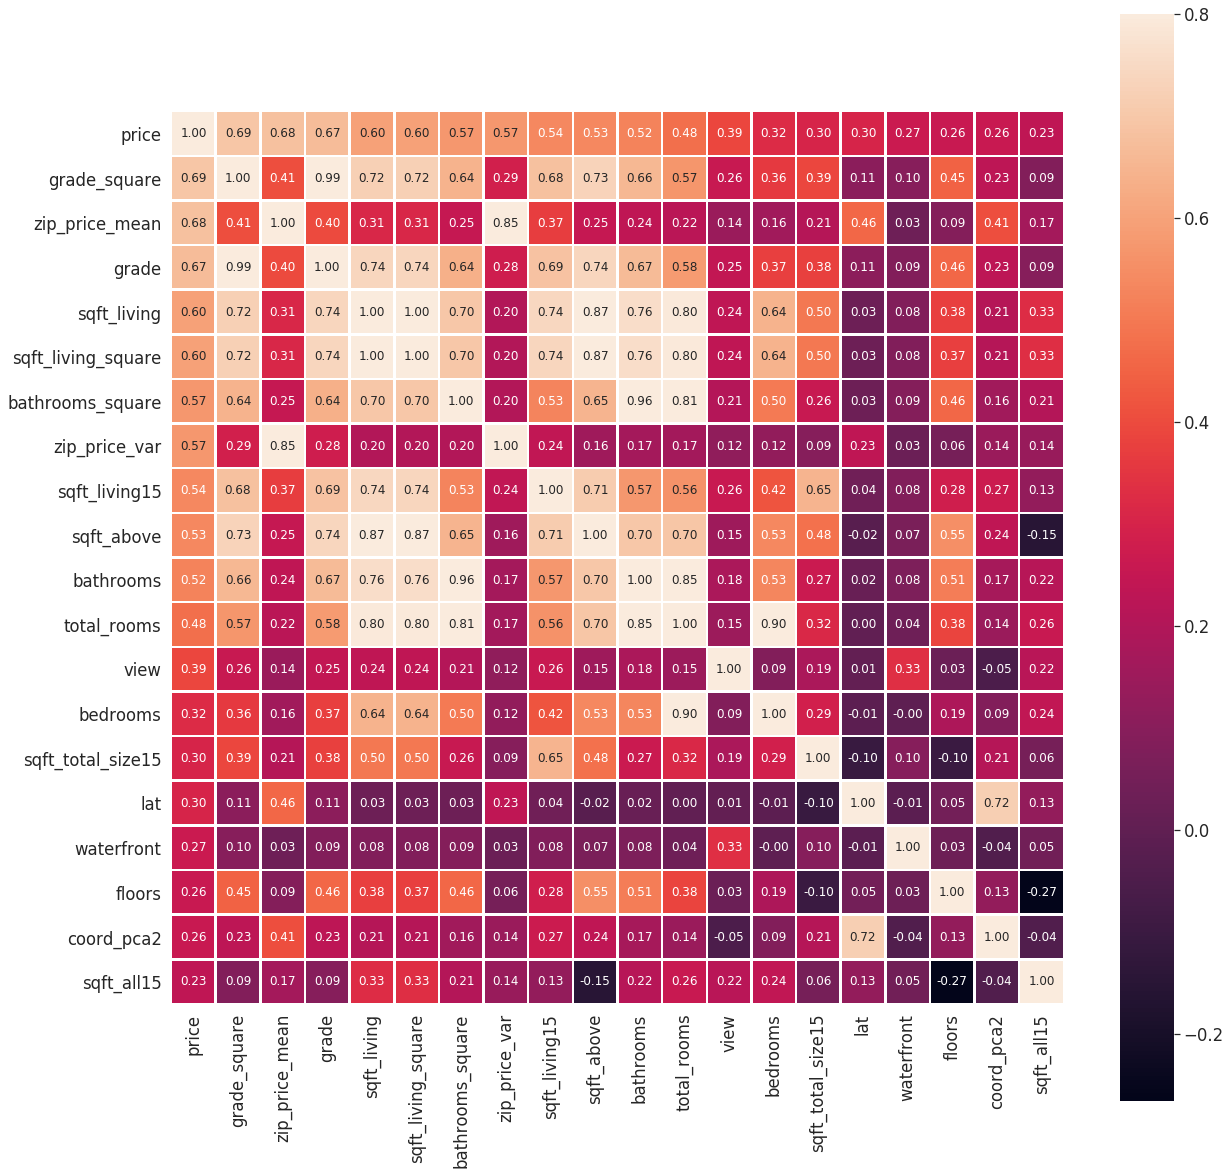

In [26]:
train_corrmat = train.corr()
k = 20
cols = train_corrmat.nlargest(k, 'price')['price'].index
cm = np.corrcoef(train[cols].values.T)
plt.figure(figsize=(20,20))
sns.set(font_scale=1.5)
sns.heatmap(cm, cbar=True, linewidths=1.5, vmax=.8, square=True, annot=True, 
            fmt='.2f', annot_kws={'size':12},
           yticklabels=cols.values, xticklabels=cols.values)   # vmax가 클수록 색깔이 짙어짐
plt.show()

In [27]:
# sns.set()
# cols = ['price','sqft_living','grade','sqft_above','total_rooms','zip_price_mean','zip_price_var']
# sns.pairplot(train[cols], size=5)
# plt.show()

del cols, k, train_corrmat, cm   # 어떻게든 메모리를 줄이기

그럼 이제 sqft_ ..series들의 skew와 kurt를 조정해보자<br>
### skewness and kurtosis of sqft_living

#### 길었다..=ㅁ=;; 이제 correlation matrix를 그려보자. 우선 양쪽에 feature들이 이쁘게 잘 들어갔나 보고나서..<br>이 만들어진 features 중에 이상한 애들이 없는지 (isnull, isnan, isna, np.inf, -np.inf, check outliers... )를 체크해보자 

In [28]:
train.columns, test.columns

(Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront',
        'view', 'condition', 'grade', 'sqft_above', 'yr_built', 'yr_renovated',
        'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'year_date',
        'yrmon_date', 'building_age', 'coord_pca1', 'coord_pca2', 'total_rooms',
        'sqft_all', 'sqft_all15', 'sqft_total_size', 'sqft_total_size15',
        'sqft_ratio15', 'sqft_ratio', 'garden_area15', 'space_for_rooms',
        'space_per_floor', 'grade_square', 'bathrooms_square',
        'sqft_lot15_square', 'sqft_living_square', 'sqft_lot_square',
        'sqft_living_gap', 'garret', 'zip_price_mean', 'zip_price_var',
        'max_distance', 'zipcode-3', 'zipcode-4', 'zipcode-5', 'zipcode-34',
        'zipcode-45', 'zipcode-35'],
       dtype='object'),
 Index(['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 'view',
        'condition', 'grade', 'sqft_above', 'yr_built', 'yr_renovated',
        'zipcode', 'lat', 'long', 'sq

In [29]:
print('train null: ', train.isnull().sum())
# print('train head: ', train.head())
print('')
print('test null: ', test.isnull().sum())
# print('test head: ', test.head())

train null:  price                 0
bedrooms              0
bathrooms             0
sqft_living           0
floors                0
waterfront            0
view                  0
condition             0
grade                 0
sqft_above            0
yr_built              0
yr_renovated          0
zipcode               0
lat                   0
long                  0
sqft_living15         0
sqft_lot15            0
year_date             0
yrmon_date            0
building_age          0
coord_pca1            0
coord_pca2            0
total_rooms           0
sqft_all              0
sqft_all15            0
sqft_total_size       0
sqft_total_size15     0
sqft_ratio15          0
sqft_ratio            0
garden_area15         0
space_for_rooms       0
space_per_floor       0
grade_square          0
bathrooms_square      0
sqft_lot15_square     0
sqft_living_square    0
sqft_lot_square       0
sqft_living_gap       0
garret                0
zip_price_mean        0
zip_price_var         0
max

============================================================================================

In [30]:
train_price = np.log1p(train.price)

train = train.drop(columns=['price'], axis=1)
print('former - train length : ', len(train))
train = train.loc[train.space_for_rooms <= 3000]  ### 3000이 넘는 애들은 outliers로 취급
print('latter - train length : ', len(train))

# print(type(train_price[0]), train_price)

former - train length :  15033
latter - train length :  15033


In [31]:
train.shape, test.shape

((15033, 47), (6468, 47))

=======================================================================
p-value를 체크함 -> multicollinearity(다중공선성) 체크<br>

https://www.kaggle.com/chocozzz/house-price-prediction-eda-updated-2019-03-12

In [32]:
# import statsmodels.api as sm

# train_columns = [c for c in train.columns if c not in ['id','date','per_price']]
# print(train_columns)
# print('')
# # print(type(train['price']))
# print('')
# print(type(train[train_columns]))

# model = sm.OLS(train_price.values, train[train_columns].astype(float))
# result = model.fit()
# print(result.summary())

In [33]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# print(train.shape, test.shape)
# vif = pd.DataFrame()

# vif['Features'] = train.columns
# vif['VIF Values'] = [variance_inflation_factor(train.values, i) 
#                      for i in range(train.shape[1])]

# vif.sort_values(by='VIF Values', ascending=False)


### multicolinearity가 있는 features가 많아서, 이런 다중공선성에 robust한 tree models을 쓴다.

In [34]:
### https://www.kaggle.com/jasonduncanwilson/predicting-iowa-house-prices

print('Columns in training data but not in testing data')
print([x for x in train.columns if x not in test.columns])
print('Columns in testing data but not in training data')
print([x for x in test.columns if x not in train.columns])

Columns in training data but not in testing data
[]
Columns in testing data but not in training data
[]


==================================================================================================<br>
Bayesian Optimization for XGBRegressor<br>
https://www.kaggle.com/toastls93/bayes-optimization-xgb

In [35]:
import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

In [36]:
xgb_search = False
xgb_simple_ver = False

### Finding effective parameters for XGBoost Regressor among the given range values

pbounds = {'num_leaves': (15, 100),        # maximum 값 50이 나와서 더 올려봄
         'min_data_in_leaf': (20, 200),    # default가 20이라 작은값도 상향 조정. 얘도 마찬가지로 max인 50이 나와서 더 올려봄
         'max_depth': (0, 20),              # 가장 작은 값인 1이 나와서 더 내려봄
         'learning_rate': (0.001, 0.5),   # 가장 작은 값인 0.001이 나와서 더 내려봄
         "min_child_samples": (0, 200),   # 작은 값인 1이 나와서 0으로, max도 상향 조정해봄.
         "feature_fraction": (0.3, 1.0),   # 0.9가 나와서 feature_fraction의 최대값인 1.0을 넣어봄
         "bagging_freq": (1, 200),         # max값이 나와서 더 올려봄. bagging_freq=0은 bagging을 안 한다는 뜻이라서, 우선 1 이상으로 둠. 
#          "bagging_fraction": (0.1, 0.9),  
           "bagging_fraction": (0.05, 0.9),  # 0.1이 나와서 더 낮은 값을 한 번 넣어봄
         "bagging_seed": (3, 500),           # max인 200이 나와서 더 높임
         "lambda_l1": (0.1, 0.9),
         "verbosity": (-1, 20),   
         "nthread": (1, 20),
         "random_state": (0, 42),
            
           ## turn on or turn off
           'subsample':(0.6, 0.9),      # 우선 이전에는 0.7x대가 안정적이었음.
          'n_estimators':(16,1000),
           'colsample_bytree':(0.5, 0.99)
          }

partially referenced code <br>
http://krasserm.github.io/2018/03/21/bayesian-optimization/

In [37]:
def XGB_cv(num_leaves, learning_rate, min_data_in_leaf, max_depth, min_child_samples, feature_fraction, bagging_freq, bagging_fraction, bagging_seed, lambda_l1, verbosity, nthread, random_state, subsample, n_estimators, colsample_bytree):
    model = xgb.XGBRegressor(num_leaves=int(num_leaves),
                             learning_rate=learning_rate,
                             min_data_in_leaf=int(min_data_in_leaf),
                             objective = 'reg:linear',
                             max_depth = int(max_depth),
                             min_child_samples = int(min_child_samples),
                             boosting = 'gbdt',
                             feature_fraction = feature_fraction,
                             bagging_freq = int(bagging_freq),
                             bagging_fraction = bagging_fraction,
                             bagging_seed = int(bagging_seed),
#                              metric = 'neg_mean_squared_error',
                             metric = 'rmse',
                             lambda_l1 = lambda_l1,
                             verbosity = verbosity,
                             nthread = int(nthread),
                             random_state = int(random_state),
                            
                             subsample = subsample,
                             n_estimators = int(n_estimators),
                            colsample_bytree = colsample_bytree
                            )
    
    RMSE = cross_val_score(model, train, train_price, cv=5).mean()
    return -RMSE

In [38]:
# def XGB_cv(num_leaves, learning_rate, min_data_in_leaf, max_depth, min_child_samples, feature_fraction, bagging_freq, bagging_fraction, bagging_seed, lambda_l1, verbosity, nthread, random_state, silent=False):
#     model = xgb.XGBRegressor(num_leaves=int(num_leaves),
#                              learning_rate=learning_rate,
#                              min_data_in_leaf=int(min_data_in_leaf),
#                              objective = 'reg:linear',
#                              max_depth = int(max_depth),
#                              min_child_samples = int(min_child_samples),
#                              boosting = 'gbdt',
#                              feature_fraction = feature_fraction,
#                              bagging_freq = int(bagging_freq),
#                              bagging_fraction = bagging_fraction,
#                              bagging_seed = int(bagging_seed),
# #                              metric = 'neg_mean_squared_error',
#                              metric = 'rmse',
#                              lambda_l1 = lambda_l1,
#                              verbosity = verbosity,
#                              nthread = int(nthread),
#                              random_state = int(random_state)
                            
#                             )
#     RMSE = cross_val_score(model, train, train_price, scoring='neg_mean_squared_error', cv=5).mean()
#     return -RMSE

In [39]:
if xgb_search:
    xgboostBO = BayesianOptimization(f=XGB_cv, pbounds=pbounds, verbose=2, random_state=42)
    xgboostBO.maximize(init_points=2, n_iter=2000)

    xgboostBO.max

In [40]:
## In case of finding hyperparameters for XGBRegressor = True

#-----------------------------------------------------------------------------------------------------------
if (xgb_search==True) & (xgb_simple_ver==False):
    xgb_param = {'num_leaves' : int(xgboostBO.max['params']['num_leaves']),
                'learning_rate' : xgboostBO.max['params']['learning_rate'],
                'min_data_in_leaf' : int(xgboostBO.max['params']['min_data_in_leaf']),
                'objective' : 'reg:linear',      # huber, gamma
#              'objective' : 'huber',
#              'objective' : 'gamma',
                'max_depth' : int(xgboostBO.max['params']['max_depth']),
                'min_child_samples' : xgboostBO.max['params']['min_child_samples'],
                'boosting' : 'gbdt',
#                  'boosting' : 'gbtree',
                'feature_fraction' : xgboostBO.max['params']['feature_fraction'],
                'bagging_freq' : int(xgboostBO.max['params']['bagging_freq']),
                'bagging_fraction' : xgboostBO.max['params']['bagging_fraction'],
                'bagging_seed' : int(xgboostBO.max['params']['bagging_seed']),
                'metric' : 'rmse',
                'lambda_l1' : xgboostBO.max['params']['lambda_l1'],
                'verbosity' : int(xgboostBO.max['params']['verbosity']),
                'nthread' : int(xgboostBO.max['params']['nthread']),
                'random_state' : int(xgboostBO.max['params']['random_state']),
                
                'subsample' : int(xgboostBO.max['params']['subsample']),
                'n_estimators' : int(xgboostBO.max['params']['n_estimators']),
                'colsample_bytree' : int(xgboostBO.max['params']['colsample_bytree'])
                }

                
#-----------------------------------------------------------------------------------------------------------

elif (xgb_search==False) & (xgb_simple_ver==False):
    xgb_param = {'num_leaves' : 50,
                'learning_rate' : 0.001,
                'min_data_in_leaf' : 80,
                'objective' : 'reg:linear',
                'max_depth' : 0,
                'min_child_samples' : 50,
                'boosting' : 'gbdt',
                'feature_fraction' : 0.4,  
                'bagging_freq' : 20,
                'bagging_fraction' : 0.86,
                'bagging_seed' : 576,
                'metric' : 'rmse',    
                'lambda_l1' : 0.81, 
                'verbosity' : 3,
                'nthread' : 5,
                'random_state' : 0}
    
else:      # 
    xgb_param = {'colsample_bytree' : 0.4603, 
                 'gamma' : 0.0468, 
                'learning_rate' : 0.05, 
                 'max_depth' : 3,
                'min_child_weight' : 1.7817, 
                 'n_estimators' : 2200,
                'reg_alpha' : 0.4640, 
                 'reg_lambda' : 0.8571,
                    'subsample' : 0.5213, 
                 'silent' : 1,
                    'random_state' : 7, 
                 'nthread' : -1}

#-----------------------------------------------------------------------------------------------------------

### parameters reference : https://www.kaggle.com/jsdae1/house-price-prediction-challenge

In [41]:
if xgb_search:
    model_xgb = xgb.XGBRegressor(num_leaves = int(xgboostBO.max['params']['num_leaves']),
                            learning_rate = xgboostBO.max['params']['learning_rate'],
                            min_data_in_leaf = int(xgboostBO.max['params']['min_data_in_leaf']),
                            objective = 'reg:linear',
                            max_depth = int(xgboostBO.max['params']['max_depth']),
                            min_child_samples = xgboostBO.max['params']['min_child_samples'],
                            boosting = 'gbdt',
                            feature_fraction = xgboostBO.max['params']['feature_fraction'],
                        bagging_freq = int(xgboostBO.max['params']['bagging_freq']),
                bagging_fraction = xgboostBO.max['params']['bagging_fraction'],
                bagging_seed = int(xgboostBO.max['params']['bagging_seed']),
                metric = 'rmse',
                lambda_l1 = xgboostBO.max['params']['lambda_l1'],
                verbosity = int(xgboostBO.max['params']['verbosity']),
                nthread = int(xgboostBO.max['params']['nthread']),
                random_state = int(xgboostBO.max['params']['random_state']),
                            
                subsample = int(xgboostBO.max['params']['subsample']),
                n_estimators = int(xgboostBO.max['params']['n_estimators']),
                colsample_bytree = int(xgboostBO.max['params']['colsample_bytree'])
                            )

    
else:
#     model_xgb = xgb.XGBRegressor(num_leaves = 50,
#                                 learning_rate = 0.001,
#                                 min_data_in_leaf = 80,
#                                 objective = 'reg:linear',          # gblinear
#                                 max_depth = 0,
#                                 min_child_samples = 50,
#                                 boosting = 'gbdt',
#                                 feature_fraction = 0.4,
#                             bagging_freq = 20,
#                     bagging_fraction = 0.86,
#                     bagging_seed = 576,
#                     metric = 'rmse',
#                     lambda_l1 = 0.81,
#                     verbosity = 3,
#                     nthread = 5,
#                     random_state = 4,

#                     subsample = 0,
#                     n_estimators = 1000,
#                     colsample_bytree = 0.85)
    
    
    model_xgb = xgb.XGBRegressor(  # num_leaves = 767,
                                learning_rate = 0.05,
#                                 min_data_in_leaf = 621,
                                objective = 'reg:linear',          # gblinear
                                max_depth = 5,         # 688
#                                 min_child_samples = 750,
                                boosting = 'gbdt',
#                                 feature_fraction = 0.7,
#                             bagging_freq = 768,
#                     bagging_fraction = 0.2,
#                     bagging_seed = 667,
                    seed = 631,
#                     metric = 'rmse',
#                     lambda_l1 = 0.55,
#                     verbosity = 10,
#                     nthread = 4,
#                     random_state = 4,

                    subsample = 0.9,    # 0
                    n_estimators = 5000,   # 1000
                    colsample_bytree = 0.4  # 0.85
    )

In [42]:
from sklearn.metrics import mean_squared_error

model_xgb.fit(train, train_price)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

print(rmsle(train_price, xgb_train_pred))

0.027127489029153965


In [43]:
### xgb_pred에 np.expm1을 해줬는데, 지우고 한 번 해보자.

res = pd.DataFrame({'id':test_id, 'price':xgb_pred})
res.to_csv('0_xgb_submission.csv', index=False)

===================================================================================================

1st LGBM model<br>
https://www.kaggle.com/junoindatascience/let-s-model-it

In [44]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV

* parameters for LGBM<br>
LGBM을 위한 Bayesian optimization은 없나?

============================== LGBM Bayesian Optimization ==============================<br>
1) https://www.kaggle.com/shep312/lightgbm-with-weighted-averages-dropout-787<br>
2) https://www.kaggle.com/sz8416/simple-bayesian-optimization-for-lightgbm<br>
3) https://www.kaggle.com/eliotbarr/stacking-test-sklearn-xgboost-catboost-lightgbm<br>
<br>
2) https://www.kaggle.com/aantonova/797-lgbm-and-bayesian-optimization<br>
2) https://www.kaggle.com/c/costa-rican-household-poverty-prediction/discussion/62582<br>
3) https://www.kaggle.com/a31314431/bayesian-optimization-lightgbm<br>
4) https://www.kaggle.com/mlisovyi/lightgbm-hyperparameter-optimisation-lb-0-761

In [45]:
## 0 : search / 1 : optimized LGBM parameters / else : simplest LGBM parameters 
lgb_search = False

### 우선은 xgb params 값들 범위 그대로 넣어줬음. 결과 보고 수정하기
lgb_pbounds = {'num_leaves': (5,500),   
             'min_data_in_leaf': (1, 200), 

             'max_depth': (0, 100),
             'learning_rate': (0.0001, 0.5),
             "min_child_samples": (0, 200),
               
             "feature_fraction": (0.3, 1.0),
             "bagging_freq": (1, 200),
               
             "bagging_fraction": (0.05, 0.9),
             "bagging_seed": (1, 200),
             
             "reg_lambda": (0.1, 0.9),
             "verbosity": (-1, 1),
             "nthread": (1, 5),
             "random_state": (0, 200),
                
               ## turn on or turn off 
                'reg_alpha': (0.1, 0.9), 
                'min_child_weight': (0.001, 0.9),
                 'min_split_gain': (1, 200),
                'drop_rate':(0.01, 0.03),
                'subsample' : (1, 200),
                'n_estimators' : (1, 200),
                'colsample_bytree' : (1, 200)}

In [46]:
def LGB_cv(num_leaves, learning_rate, min_data_in_leaf, max_depth, min_child_samples, feature_fraction, bagging_freq, bagging_fraction, bagging_seed, reg_lambda, verbosity, nthread, random_state, 
           reg_alpha, min_child_weight, min_split_gain, drop_rate, subsample, n_estimators, colsample_bytree, silent=False):
    
    model = lgb.LGBMRegressor(num_leaves=int(num_leaves),
                             learning_rate=learning_rate,
                             min_data_in_leaf=int(min_data_in_leaf),
                             objective = 'huber',
#                               objective = 'gamma',
                             max_depth = int(max_depth),
                             min_child_samples = int(min_child_samples),
                             boosting = 'gbdt',
                             feature_fraction = feature_fraction,
                             bagging_freq = int(bagging_freq),
                             bagging_fraction = bagging_fraction,
                             bagging_seed = int(bagging_seed),
                            reg_lambda = reg_lambda,
                             metric = 'rmse',
                             verbosity = int(verbosity),
                             nthread = int(nthread),
                             random_state = int(random_state),
                              
                              reg_alpha = reg_alpha,
                              min_child_weight = min_child_weight,
                              min_split_gain = min_split_gain,
                              drop_rate = drop_rate,
                              subsample = int(subsample),
                              colsample_bytree = int(colsample_bytree))
    
    RMSE = cross_val_score(model, train, train_price, scoring='neg_mean_squared_error', cv=5).mean()
    return -RMSE

In [47]:
if lgb_search:
    lgboostBO = BayesianOptimization(f=LGB_cv, pbounds=lgb_pbounds, verbose=2, random_state=42)
    lgboostBO.maximize(init_points=2, n_iter=100)

    lgboostBO.max

In [48]:
# if lgb_search:
#     lgb_param = {'num_leaves': int(lgboostBO.max['params']['num_leaves']),   
#              'min_data_in_leaf': int(lgboostBO.max['params']['min_data_in_leaf']), 
#              'objective':'huber',   # 'huber', 'gamma'

#              'max_depth': int(lgboostBO.max['params']['max_depth']),
#              'learning_rate': lgboostBO.max['params']['learning_rate'],
#              "min_child_samples": int(lgboostBO.max['params']['min_child_samples']),
#              "boosting": "dart",     # dart, gdbt
#              "feature_fraction": lgboostBO.max['params']['feature_fraction'],
#              "bagging_freq": int(lgboostBO.max['params']['bagging_freq']),
#              "bagging_fraction": lgboostBO.max['params']['bagging_fraction'],
#              "bagging_seed": int(lgboostBO.max['params']['bagging_seed']),
#              "metric": 'rmse',
#     #          "lambda_l1": 0.1,
#              "reg_lambda": int(lgboostBO.max['params']['reg_lambda']),
#              "verbosity": int(lgboostBO.max['params']['verbosity']),
#              "nthread": int(lgboostBO.max['params']['nthread']),
#              "random_state": int(lgboostBO.max['params']['random_state']),
                
#                ## turn on or turn off 
#                 'reg_alpha':lgboostBO.max['params']['reg_alpha'], 
# #             'scale_pos_weight': int(lgboostBO.max['params']['scale_pos_weight']),
#                 'min_child_weight': int(lgboostBO.max['params']['min_child_weight']),
#                  'min_split_gain': lgboostBO.max['params']['min_split_gain'],
#                 'drop_rate':lgboostBO.max['params']['drop_rate'],
#                 'subsample' : int(lgboostBO.max['params']['subsample']),
#                 'n_estimators' : int(lgboostBO.max['params']['n_estimators']),
#                 'colsample_bytree' : int(lgboostBO.max['params']['colsample_bytree'])}
    

# else:      # 이거는 수원 스터디 커널의 파라미터들
#     lgb_param = {
# #         'objective': 'huber',         # no effect
#           'boosting_type' : 'gbdt',
#             'num_leaves' : 4,        # 원래 6이었는데, overfit이 있어서 4로 다운
#             'min_child_samples' : 10,  # 원래 40
# #             'min_data_in_lear' : 30,    # 원래 50 -> NO EFFECT
#             'lambda_l1' : 1.5,        # 원래 0.1
#             'lambda_l2' : 0.5,       # 원래 0.1
#             'learning_rate' : 0.05,   # 원래 0.09
# #                 'subsample' : 0.1,   # 원래 0.9 -no effect
#                   'metric':'rmse',
#             'bagging_fraction' : 0.9,  # 원래 0.1
# #                  'baggin_freq' : 20,   # 원래 6 - 영향없음
#                  'feature_fraction' : 0.01,   # 원래 0.001
#                  'min_sum_hessian_in_leaf' : 10,
#                  'num_threads' : 5,
#                  'verbosity' : 2}

    
#     lgb_param = {'num_leaves': 30,
#                 'feature_fraction':0.5,
#                  'bagging_Fraction':0.9,
#                  'max_depth':7,
#                  'lambda_l1':3,
#                  'lambda_l2':3,
#                  'min_split_gain':0.01,
#                  'min_child_weight':30,
#                 'metric':'rmse'}


##################### original LGBM parameters 
lgb_param = {'num_leaves': 35,
     'min_data_in_leaf': 30, 
     'objective':'huber',
#              'objective':'gamma',
     'max_depth': -1,
     'learning_rate': 0.001,
     "min_child_samples": 20,
     "boosting": "gbdt",
     "feature_fraction": 0.9,
     "bagging_freq": 1,
     "bagging_fraction": 0.9 ,
#          "bagging_fraction": 0.7,
     "bagging_seed": 11,
     "metric": 'rmse',
#          "lambda_l1": 0.1,
     "reg_lambda": 10,
     "verbosity": -1,
     "nthread": 4,
     "random_state": 0}

In [49]:
# folds = KFold(n_splits=5, shuffle=False, random_state=42)   # 원래는 shuffle = True로 했었음. 
# oof = np.zeros(len(train))
# predictions = np.zeros(len(test))
# feature_importance_df = pd.DataFrame()

# #run model
# for fold_, (trn_idx, val_idx) in enumerate(folds.split(train)):
#     trn_data = lgb.Dataset(train.iloc[trn_idx], label=train_price.iloc[trn_idx])
#     val_data = lgb.Dataset(train.iloc[val_idx], label=train_price.iloc[val_idx])

#     num_round = 30000
#     clf = lgb.train(lgb_param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=5000, early_stopping_rounds = 10000)
#     oof[val_idx] = clf.predict(train.iloc[val_idx], num_iteration=clf.best_iteration)
    
#     fold_importance_df = pd.DataFrame()
#     fold_importance_df["Feature"] = train.columns
#     fold_importance_df["importance"] = clf.feature_importance()
#     fold_importance_df["fold"] = fold_ + 1
    
#     feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
#     predictions += clf.predict(test, num_iteration=clf.best_iteration) / folds.n_splits
    
# cv = np.sqrt(mean_squared_error(oof, train_price))
# print(cv)

In [50]:
# cv1 = np.sqrt(mean_squared_error(oof, train_price))
# print(cv1)

In [51]:
# cols = (feature_importance_df[['Feature','importance']].groupby('Feature').mean()
#        .sort_values(by='importance', ascending=False)[:1000].index)

# best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

# plt.figure(figsize=(14, 26))
# sns.barplot(x='importance', y='Feature', data=best_features.sort_values(by='importance', ascending=False))
# plt.title('LGBM features (averaged over folds)')
# plt.tight_layout()

In [52]:
# res = pd.DataFrame({'id':test_id, 'price':np.expm1(predictions)})
# res.to_csv('1st_lgb_submission.csv', index=False)

2nd LGBM model<br>
https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

In [53]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [54]:
# model_lgb = lgb.LGBMRegressor(num_leaves = 35,
#          min_data_in_leaf = 30, 
#          objective = 'huber',
# #              objective = 'gamma',
#          max_depth = -1,
#          learning_rate = 0.001,
#          min_child_samples = 20,
#         boosting = 'gbdt',
# #          feature_fraction = 0.9,
#         feature_fraction = 0.5,
#          bagging_freq = 1,
# #          bagging_fraction = 0.9 ,
#          bagging_fraction = 0.7,
#          bagging_seed = 11,
#          metric = 'rmse',
# #          "lambda_l1": 0.1,
#          reg_lambda = 20,
#         reg_lambda = 10,
#          verbosity = -1,
#          nthread = 4,
#          random_state = 0)

# model_lgb.fit(train, train_price)
# lgb_train_pred = model_lgb.predict(train)
# lgb_pred = np.expm1(model_lgb.predict(test.values))
# lgb_pred = model_lgb.predict(test.values)
# print(rmsle(train_price, lgb_train_pred))

In [55]:
# res = pd.DataFrame({'id':test_id, 'price':lgb_pred})
# res.to_csv('2nd_lgb_submission.csv', index=False)

-------------------------------------------------------------------------------<br>
Stacking <br>
https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

In [56]:
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [57]:
n_folds = 5

# def rmsle_cv(model):
#     kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
#     rmse = np.sqrt(-cross_val_score(model, train.values, train_price, 
#                          scoring='neg_mean_squared_error',cv=kf))
#     return rmse

In [58]:
#### LASSO
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))

#### ELASTIC NET REGRESSION
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

#### KERNEL RIDGE REGRESSION
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

#### GRADIENT BOOSTING REGRESSION
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4,
                                  max_features='sqrt', min_samples_leaf=15, min_samples_split=10,
                                  loss='huber', random_state=5)

#### XGBOOST    # 현재 원본 코드에 있는 xgb parameters 를 넣은거임
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)


# #### LIGHTGBM 
model_lgb = lgb.LGBMRegressor(objective='regression', num_leaves=5, learning_rate=0.05,
                             n_estimators=720, max_bin=55, bagging_fraction=0.8,
                             bagging_freq=5, feature_fraction=0.3,
                             feature_fraction_seed=9, 
                              bagging_seed=9, min_data_in_leaf=6,
                             min_sum_hessian_in_leaf=11)

Base models scores

In [59]:
# score = rmsle_cv(lasso)
# print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
# print('')
# score = rmsle_cv(ENet)
# print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
# print('')
# score = rmsle_cv(KRR)
# print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
# print('')
# score = rmsle_cv(GBoost)
# print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
# print('')
# score = rmsle_cv(model_xgb)
# print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
# print('')
# score = rmsle_cv(model_lgb)
# print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))
# print('')

### STACKING

In [60]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=0)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [61]:
# stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR), meta_model = lasso)

# print(stacked_averaged_models)

# # score = rmsle_cv(stacked_averaged_models)
# # print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

### Ensembling StackedRegressor, XGBoost and LightGBM

In [62]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [63]:
# #### stacked Regressor
# stacked_averaged_models.fit(train.values, train_price)
# stacked_train_pred = stacked_averaged_models.predict(train.values)
# stacked_pred = stacked_averaged_models.predict(test.values)
# print(rmsle(train_price, stacked_train_pred))

# #### XGBoost
# model_xgb.fit(train, train_price)
# xgb_train_pred = model_xgb.predict(train)
# xgb_pred = model_xgb.predict(test)
# print(rmsle(train_price, xgb_train_pred))

# # #### LightGBM
# model_lgb.fit(train, train_price)
# lgb_train_pred = model_lgb.predict(train)
# lgb_pred = np.expm1(model_lgb.predict(test.values))
# lgb_pred = model_lgb.predict(test.values)
# print(rmsle(train_price, lgb_train_pred))

# # ################################# RMSE on the entire train data when averaging
# print('RMSE score on train data:')
# print(rmsle(train_price, stacked_train_pred*0.90 + xgb_train_pred*0.05 + lgb_train_pred*0.05))

In [64]:
# sub = pd.DataFrame()
# sub['id'] = test_id
# sub['price'] = stacked_pred
# sub.to_csv('3rd_stacked_pred.csv', index=False)

# sub['price'] = xgb_pred
# sub.to_csv('4th_xgb_pred.csv', index=False)

# sub['price'] = lgb_pred
# sub.to_csv('5th_lgb_pred.csv', index=False)

In [65]:
# ensemble = stacked_pred*0.90 + xgb_pred*0.05 + lgb_pred*0.05
# ensemble = stacked_pred*0.90 + xgb_pred*0.10

In [66]:
# sub = pd.DataFrame()
# sub['id'] = test_id
# sub['price'] = ensemble
# sub.to_csv('final_ensemble_submission.csv',index=False)

### feature importances

In [67]:
# from sklearn.model_selection import train_test_split
# import eli5
# from eli5.sklearn import PermutationImportance
# from IPython.display import display


# x_train, x_val, y_train, y_val = train_test_split(train, train_price, test_size=0.2, random_state=1)

# ########################### GradientBoostingRegressor ###########################
# model = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4,
#                                   max_features='sqrt', min_samples_leaf=15, min_samples_split=10,
#                                   loss='huber', random_state=5)

# model.fit(x_train, y_train)
# # pd.Series(model.feature_importances_, train.columns).sort_values(ascending=True).plot.barh(width=0.8, ax=ax[0, 0])
# print('::::: GB regressor importances -------------------------------\n', pd.Series(model.feature_importances_, x_train.columns).sort_values(ascending=True))
# print('\n-----------------------------------------------------------------\n')
# perm = PermutationImportance(model, random_state=1).fit(x_val, y_val)
# print('\n::::: GB regressor permutation importances -----------------------------------------------------------------\n')
# display(eli5.show_weights(perm, feature_names=x_val.columns.tolist()))
# # ax[0, 0].set_title('Feature importance in GradientBoostingRegressor')
# print('\n-----------------------------------------------------------------\n')
# print('\n-----------------------------------------------------------------\n')


# # ########################### XGBoostRegressor ###########################
# # model = xgb.XGBRegressor(colsample_by_tree=0.8, learning_rate=0.001, max_depth=6,
# #                             min_child_weight=0.8, n_estimators=10000, silent=1)

# if search:
#     mode; = xgb.XGBRegressor(max_depth=int(xgboostBO.max['params']['max_depth']),
#                                  learning_rate=xgboostBO.max['params']['learning_rate'],
#                                  n_estimators=int(xgboostBO.max['params']['n_estimators']),
#                                  gamma=xgboostBO.max['params']['gamma'],
#                                  min_child_weight=xgboostBO.max['params']['min_child_weight'],
#                                  max_delta_step=xgboostBO.max['params']['max_delta_step'],
#                                  subsample=xgboostBO.max['params']['subsample'],
#                                  colsample_bytree=xgboostBO.max['params']['colsamplle_bytree'])
    
# else:
#     model = xgb.XGBRegressor(colsample_by_tree=0.8, learning_rate=0.001, max_depth=6,
#                                 min_child_weight=0.8, n_estimators=10000, silent=1)

# model.fit(x_train, y_train)
# print('\n::::: XGB regressor importances ===================\n ', pd.Series(model.feature_importances_, x_train.columns).sort_values(ascending=True))
# print('\n-----------------------------------------------------------------\n')
# perm = PermutationImportance(model, random_state=1).fit(x_val, y_val)
# print('\n::::: XGB regressor permutation importances -----------------------------------------------------------------\n')
# display(eli5.show_weights(perm, feature_names=x_val.columns.tolist()))
# # ax[0, 1].set_title('feature importance in XGBoostRegressor')

# # ########################### LightGBM Regressor ###########################
# model = lgb.LGBMRegressor(objective='regression', num_leaves=5, learning_rate=0.001,
#                              n_estimators=720, max_bin=55, bagging_fraction=0.8,
#                              bagging_freq=5, feature_fraction=0.3,
#                              feature_fraction_seed=9, 
#                               bagging_seed=9, min_data_in_leaf=6,
#                              min_sum_hessian_in_leaf=11)

# model.fit(x_train, y_train)
# # pd.Series(model.feature_importances_, train.columns).sort_values().plot.barh(width=0.8, ax=ax[1, 0], cmap='RdYlGn_r')
# print('\n::::: LGBM regressor importances ----------------------------\n ', pd.Series(model.feature_importances_, x_train.columns).sort_values())
# print('\n-----------------------------------------------------------------\n')
# perm = PermutationImportance(model, random_state=1).fit(x_val, y_val)
# print('\n::::: LGBM regressor permutation importances -----------------------------------------------------------------\n')
# display(eli5.show_weights(perm, feature_names=x_val.columns.tolist()))
# # ax[1, 0].set_title('feature importance in LGBM Regressor')


# # ########################### XGBoost Classifier ###########################
# # model = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.01)
# # model.fit(x_train, y_train)
# # # pd.Series(model.feature_importances_, train.columns).sort_values().plot.barh(width=0.8, ax=ax[1, 1], color='#FD0F00')
# # print('>>>>> XGB classifier importances *****************************\n ', pd.Series(model.feature_importances_, x_train.columns).sort_values())
# # print('\n-----------------------------------------------------------------\n')
# # perm = PermutationImportance(model, random_state=1).fit(x_val, y_val)
# # print('\n::::: XGB classifier permutation importances -----------------------------------------------------------------\n')
# # display(eli5.show_weights(perm, feature_names=x_val.columns.tolist()))
# # # ax[1, 1].set_title('feature importance in XGBoost classifier')
# # # plt.show()